In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

In [10]:
from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib

# 한글깨짐
#fm.get_fontconfig_fonts()
#font_location = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'

#font_name = fm.FontProperties(fname=font_location).get_name()
#matplotlib.rc('font', family=font_name)

In [11]:
"""
    총 aspect : 25개
    제품 전체 : 품질, 디자인, 편의성, 일반, 가격, 다양성, 인지도 (7개)
    패키지/구성품 : 디자인, 다양성, 일반, 편의성, 품질, 가격 (6개)
    본품 : 일반, 다양성, 품질, 인지도, 편의성, 디자인, 가격 (7개)
    브랜드 : 일반, 인지도, 디자인, 품질, 가격 (5개)

    sentiment : negative, netural, positive (3개)
"""

'\n    총 aspect : 25개\n    제품 전체 : 품질, 디자인, 편의성, 일반, 가격, 다양성, 인지도 (7개)\n    패키지/구성품 : 디자인, 다양성, 일반, 편의성, 품질, 가격 (6개)\n    본품 : 일반, 다양성, 품질, 인지도, 편의성, 디자인, 가격 (7개)\n    브랜드 : 일반, 인지도, 디자인, 품질, 가격 (5개)\n\n    sentiment : negative, netural, positive (3개)\n'

In [12]:
# TRAIN_DATA_PATH= './jsonl_data/nikluge-sa-2022-train.jsonl'
DEV_DATA_PATH= 'output_file/tunib_best.jsonl'
# TEST_DATA_PATH= './jsonl_data/nikluge-sa-2022-test.jsonl'

In [13]:
def read_jsonl(path):
    data= []
    with open(path, 'r') as f:
        for i, line in tqdm(enumerate(f)):
            data.append(json.loads(line))
    
    return data

In [14]:
# trainset= read_jsonl(TRAIN_DATA_PATH)
devset= read_jsonl(DEV_DATA_PATH)
# testset= read_jsonl(TEST_DATA_PATH)

2127it [00:00, 147671.60it/s]


In [15]:
def convert_jsonl_to_df(jsonl_data):
    multi_label_count_dict= defaultdict(lambda: 0)
    data_dict= defaultdict(list)
    for js_data in tqdm(jsonl_data):
        id, sentence, annotation= js_data['id'], js_data['sentence_form'], js_data['annotation']
        
        for annot in annotation:
            tmp_aspect, sentiment= annot
            aspect_1, aspect_2= tmp_aspect.split('#')
            data_dict['id'].append(id)
            data_dict['sentence'].append(sentence)
            data_dict['aspect_1'].append(aspect_1)
            data_dict['aspect_2'].append(aspect_2)
            data_dict['aspect_concat'].append(str(aspect_1) + '#' + str(aspect_2))
            data_dict['sentiment'].append(sentiment)
            
        multi_label_count_dict[len(annotation)]+= 1
    print(multi_label_count_dict)
    
    plot_multi_label(multi_label_count_dict)
    return pd.DataFrame(data_dict)

def plot_multi_label(count_dict):
    ax=sns.barplot(x=list(count_dict.keys()), y = [count_dict[k] for k in count_dict.keys()])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 15)
    plt.title("example별 annotation count")
    plt.show()



100%|██████████| 2127/2127 [00:00<00:00, 493679.63it/s]
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)


defaultdict(<function convert_jsonl_to_df.<locals>.<lambda> at 0x7f125552cee0>, {1: 2005, 2: 119, 3: 3})


/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0, flags=flags)


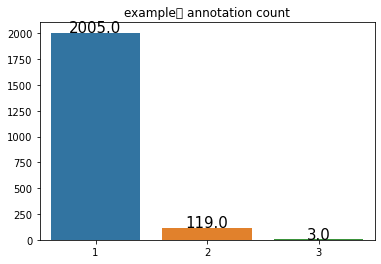

,id,sentence,aspect_1,aspect_2,aspect_concat,sentiment
0,nikluge-sa-2022-test-00001,하나 사려고 알아보는 중인데 맘에드는거 발견,제품 전체,일반,제품 전체#일반,positive
1,nikluge-sa-2022-test-00002,동양인 피부톤과 잘 어울리고 우아한 분위기를 풍긴다네?,제품 전체,디자인,제품 전체#디자인,positive
2,nikluge-sa-2022-test-00003,근데 이건 마르살라보다 더 지나친 색 같은데..,본품,일반,본품#일반,negative
3,nikluge-sa-2022-test-00004,나스 색조가 다 그렇지만서도 어데이셔스 라인은 진짜 색 기막히게 뽑는것 같다,제품 전체,디자인,제품 전체#디자인,positive
4,nikluge-sa-2022-test-00005,색상만 보면 이걸 어떻게 발라.. 싶겠지만 의외로 너무너무 괜찮다,본품,일반,본품#일반,positive


In [16]:
# dev_df= convert_jsonl_to_df(trainset) 
dev_df= convert_jsonl_to_df(devset)
dev_df.head()

In [17]:
"""
    일단 기본적으로 aspect_1, aspect_2, aspect_concat, sentiment 기준으로 eda

    multi annotation되어진 경우가 생각보다 많음.
    aspect 관점에서 무엇을 label로 학습을 시켜야 하는가?
    1. 0번째 index만 -> 제일 simple
    2. 모든 annotation 학습 -> 학습 데이터 수는 늘어나겠지만 label이 ambiguous -> 현재 사용한 방법
    3. annotation들 중 hard-voting하여 top-1 사용 -> label 3개 이상인 경우가 얼마 없으므로 성능에 별 의미는 없을 듯 -> 성능 쥐어짜낼 때 시도를 해볼 여지는 있는듯
"""


'\n    일단 기본적으로 aspect_1, aspect_2, aspect_concat, sentiment 기준으로 eda\n\n    multi annotation되어진 경우가 생각보다 많음.\n    aspect 관점에서 무엇을 label로 학습을 시켜야 하는가?\n    1. 0번째 index만 -> 제일 simple\n    2. 모든 annotation 학습 -> 학습 데이터 수는 늘어나겠지만 label이 ambiguous -> 현재 사용한 방법\n    3. annotation들 중 hard-voting하여 top-1 사용 -> label 3개 이상인 경우가 얼마 없으므로 성능에 별 의미는 없을 듯 -> 성능 쥐어짜낼 때 시도를 해볼 여지는 있는듯\n'

/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py

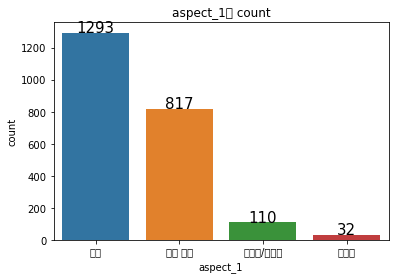

In [18]:
ax= sns.countplot(x= 'aspect_1', data=dev_df, order = dev_df['aspect_1'].value_counts().index)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 15)
plt.title("aspect_1별 count")
plt.show()

/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51656 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py

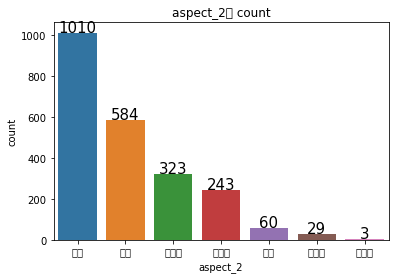

In [19]:
ax= sns.countplot(x= 'aspect_2', data=dev_df, order = dev_df['aspect_2'].value_counts().index)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 15)
plt.title("aspect_2별 count")
plt.show()

/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51656 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py

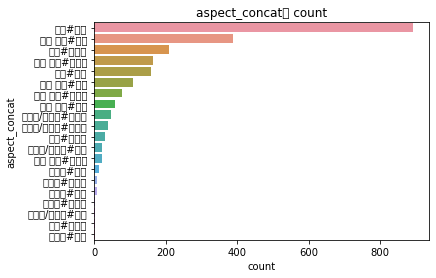

In [20]:
ax= sns.countplot(y= 'aspect_concat', data=dev_df, order = dev_df['aspect_concat'].value_counts().index)
plt.title("aspect_concat별 count")
plt.show()


In [21]:
dev_df.groupby('aspect_concat').count()

,id,sentence,aspect_1,aspect_2,sentiment
aspect_concat,,,,,
본품#다양성,3,3,3,3,3
본품#디자인,29,29,29,29,29
본품#일반,160,160,160,160,160
본품#편의성,208,208,208,208,208
본품#품질,893,893,893,893,893
브랜드#가격,1,1,1,1,1
브랜드#디자인,3,3,3,3,3
브랜드#인지도,8,8,8,8,8
브랜드#일반,13,13,13,13,13


In [22]:
corr_df= dev_df.groupby('id')['aspect_concat'].apply(list)
combine_dict= defaultdict(lambda: 0)
cnt= 0
for val in corr_df.values:
  if '제품 전체#일반' in val and '본품#품질' in val:
    cnt+=1

  if len(val)!= 1: # for multi annot
    combine_dict[str(val)]+=1
print(combine_dict)
print(cnt)
# 결과 해석 multi annot의 경우 '본품#품질'이 중복되서 나오는 경우가 제일 많았고 대다수 aspect_1이 같고 aspect_2가 다른 case가 많았음

defaultdict(<function <lambda> at 0x7f1254b44a60>, {"['본품#품질', '본품#일반']": 15, "['본품#일반', '본품#디자인']": 2, "['본품#품질', '제품 전체#일반', '제품 전체#가격']": 1, "['본품#품질', '제품 전체#일반']": 1, "['본품#품질', '패키지/구성품#디자인']": 3, "['본품#품질', '제품 전체#디자인']": 6, "['제품 전체#품질', '제품 전체#편의성']": 6, "['패키지/구성품#품질', '패키지/구성품#디자인']": 1, "['본품#편의성', '본품#디자인']": 2, "['본품#품질', '브랜드#디자인']": 1, "['본품#일반', '본품#편의성']": 2, "['본품#품질', '본품#편의성']": 33, "['본품#품질', '패키지/구성품#편의성']": 2, "['패키지/구성품#일반', '패키지/구성품#편의성']": 3, "['본품#일반', '제품 전체#디자인']": 1, "['본품#품질', '제품 전체#인지도']": 1, "['제품 전체#일반', '제품 전체#가격']": 1, "['제품 전체#일반', '본품#편의성', '제품 전체#디자인']": 1, "['제품 전체#일반', '본품#편의성']": 1, "['제품 전체#편의성', '제품 전체#디자인']": 1, "['제품 전체#품질', '제품 전체#가격']": 7, "['제품 전체#품질', '제품 전체#일반']": 3, "['제품 전체#품질', '제품 전체#디자인']": 8, "['제품 전체#편의성', '제품 전체#가격']": 1, "['제품 전체#품질', '본품#품질']": 2, "['본품#품질', '본품#디자인']": 3, "['본품#편의성', '제품 전체#가격']": 1, "['본품#품질', '제품 전체#편의성']": 4, "['본품#품질', '제품 전체#가격']": 4, "['본품#편의성', '본품#다양성']": 1, "['본품#편의성', '제품 전체#디자인']": 1, "['제품 전체#품

/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0, flags=flags)


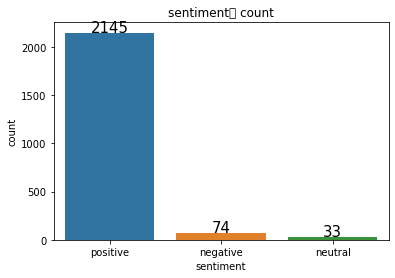

In [23]:
ax= sns.countplot(x= 'sentiment', data=dev_df, order = dev_df['sentiment'].value_counts().index)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 15)
plt.title("sentiment별 count")
plt.show()